# Benchmark code inter-processo

In questo notebook si vogliono evidenziare prestazioni e possibili criticità
della coda utilizzata per la comunicazione interprocesso, ossia
`multiprocessing.Queue`.

La coda permette di implementare facilmente un paradigma _produttore-consumatore_
largamente usato per distribuire task a dei processi _worker_.

Essendo la comunicazione inter-processo, ogni oggetto inserito nella coda viene
serializzato e viene deserializzato nel momento in cui viene estratto. Il modulo
usato per serializzare i vari oggetti è `pickle`.

Il benchmark è molto semplice: verranno inseriti e rimossi vari oggetti, di
diverse dimensioni nella coda. Lo stesso oggetto verrà inserito (e rimosso) 100
volte al fine di avere un dato statistico solido. Saranno poi calcolati tempo
medio e deviazione standard dei tempi di inserimento e rimozione dalla coda.

Come oggetto da inviare utilizzeremo degli array `numpy`, i quali hanno una
dimensione ben definita, sia in termini di struttura, sia in termini di
attributi.


In [1]:
import numpy as np

a = np.array([i for i in range(10)])
print(f"numpy array size: {a.nbytes} bytes")

numpy array size: 80 bytes


Come ci si poteva aspettare, `numpy` inizializza vettori di valori a 8 byte
a meno che non si specifichi un tipo diverso.

Definiamo quindi la funzione che testa le prestazioni di inserimento e rimozione
in questo modo:


In [2]:
import multiprocessing as mp
import time
import matplotlib.pyplot as plt


def benchmark(dim: int):
    q = mp.Queue()
    buffer = np.array([i for i in range(dim)])
    print(f"dimension: {dim}, bytes: {buffer.nbytes}")

    put_times = []
    get_times = []
    for _ in range(100):
        start = time.perf_counter()
        q.put(buffer)
        end_put = time.perf_counter()
        q.get()
        end = time.perf_counter()

        put_times.append(end_put - start)
        get_times.append(end - end_put)

    return np.mean(put_times), np.std(put_times), np.mean(get_times), np.std(get_times)


dims = np.around(np.geomspace(10, 5242880, 20)).astype(int)
dims

array([     10,      20,      40,      80,     160,     320,     640,
          1280,    2560,    5120,   10240,   20480,   40960,   81920,
        163840,  327680,  655360, 1310720, 2621440, 5242880])

Non rimane che effettuare i test su varie dimensioni.


In [3]:
put_means = []
put_stds = []
get_means = []
get_stds = []

for d in dims:
    put_mean, put_std, get_mean, get_std = benchmark(d)
    print(f" put: ({put_mean:.5f}, {put_std:.5f})")
    print(f" get: ({get_mean:.5f}, {get_std:.5f})")

    put_means.append(put_mean)
    put_stds.append(put_std)

    get_means.append(get_mean)
    get_stds.append(get_std)


dimension: 10, bytes: 80
 put: (0.00001, 0.00003)
 get: (0.00006, 0.00005)
dimension: 20, bytes: 160
 put: (0.00001, 0.00002)
 get: (0.00005, 0.00003)
dimension: 40, bytes: 320
 put: (0.00001, 0.00002)
 get: (0.00006, 0.00005)
dimension: 80, bytes: 640
 put: (0.00001, 0.00004)
 get: (0.00006, 0.00004)
dimension: 160, bytes: 1280
 put: (0.00001, 0.00005)
 get: (0.00005, 0.00005)
dimension: 320, bytes: 2560
 put: (0.00001, 0.00004)
 get: (0.00005, 0.00003)
dimension: 640, bytes: 5120
 put: (0.00001, 0.00002)
 get: (0.00005, 0.00003)
dimension: 1280, bytes: 10240
 put: (0.00001, 0.00003)
 get: (0.00006, 0.00004)
dimension: 2560, bytes: 20480
 put: (0.00001, 0.00003)
 get: (0.00006, 0.00002)
dimension: 5120, bytes: 40960
 put: (0.00001, 0.00002)
 get: (0.00007, 0.00003)
dimension: 10240, bytes: 81920
 put: (0.00001, 0.00002)
 get: (0.00009, 0.00003)
dimension: 20480, bytes: 163840
 put: (0.00001, 0.00002)
 get: (0.00012, 0.00005)
dimension: 40960, bytes: 327680
 put: (0.00001, 0.00002)
 ge

Abbiamo quindi esaminato una serie di possibili valori, da 80 byte a 40 MB.
Vediamo come si sviluppa il grafico.


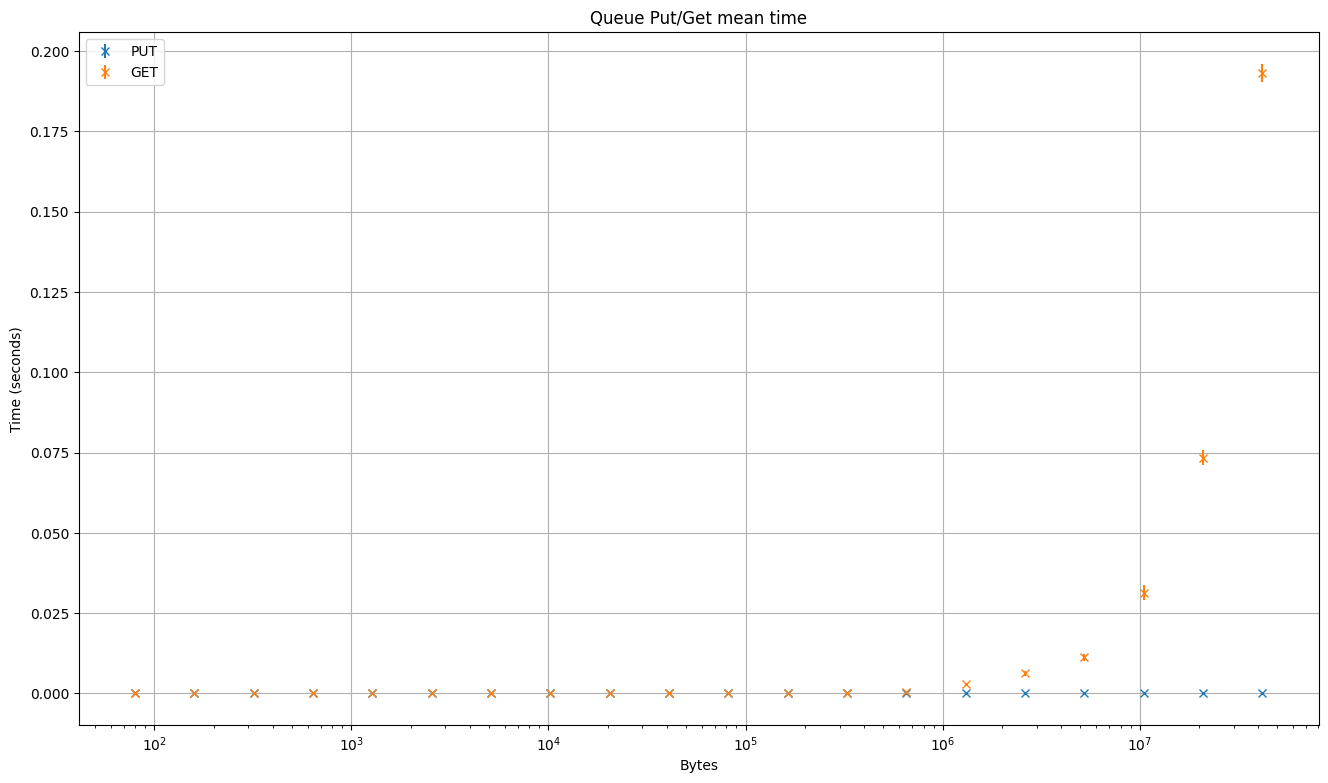

In [4]:
plt.figure(figsize=(16, 9))
plt.title("Queue Put/Get mean time")
plt.xlabel("Bytes")
plt.ylabel("Time (seconds)")

plt.errorbar(dims * 8, put_means, put_stds, linestyle="None", marker="x", label="PUT")
plt.errorbar(dims * 8, get_means, get_stds, linestyle="None", marker="x", label="GET")

plt.legend()
plt.xscale("log")
plt.grid()
plt.show()

In [5]:
import pickle


def benchmark_pickle(dim: int):
    buffer = np.array([i for i in range(dim)])
    print(f"dimension: {dim}, bytes: {buffer.nbytes}")

    dump_times = []
    load_times = []
    for _ in range(100):
        start = time.perf_counter()
        data = pickle.dumps(buffer)
        end_put = time.perf_counter()
        pickle.loads(data)
        end = time.perf_counter()

        dump_times.append(end_put - start)
        load_times.append(end - end_put)

    return (
        np.mean(dump_times),
        np.std(dump_times),
        np.mean(load_times),
        np.std(load_times),
    )

In [6]:
dump_means = []
dump_stds = []
load_means = []
load_stds = []

for d in dims:
    dump_mean, dump_std, load_mean, load_std = benchmark_pickle(d)
    print(f" dump: ({dump_mean:.5f}, {dump_std:.5f})")
    print(f" load: ({load_mean:.5f}, {load_std:.5f})")

    dump_means.append(dump_mean)
    dump_stds.append(dump_std)

    load_means.append(load_mean)
    load_stds.append(load_std)


dimension: 10, bytes: 80
 dump: (0.00002, 0.00001)
 load: (0.00001, 0.00001)
dimension: 20, bytes: 160
 dump: (0.00002, 0.00001)
 load: (0.00002, 0.00009)
dimension: 40, bytes: 320
 dump: (0.00001, 0.00001)
 load: (0.00001, 0.00000)
dimension: 80, bytes: 640
 dump: (0.00001, 0.00001)
 load: (0.00001, 0.00000)
dimension: 160, bytes: 1280
 dump: (0.00001, 0.00001)
 load: (0.00001, 0.00000)
dimension: 320, bytes: 2560
 dump: (0.00002, 0.00008)
 load: (0.00001, 0.00001)
dimension: 640, bytes: 5120
 dump: (0.00002, 0.00007)
 load: (0.00001, 0.00001)
dimension: 1280, bytes: 10240
 dump: (0.00001, 0.00001)
 load: (0.00001, 0.00000)
dimension: 2560, bytes: 20480
 dump: (0.00002, 0.00001)
 load: (0.00001, 0.00001)
dimension: 5120, bytes: 40960
 dump: (0.00001, 0.00001)
 load: (0.00001, 0.00000)
dimension: 10240, bytes: 81920
 dump: (0.00002, 0.00001)
 load: (0.00001, 0.00001)
dimension: 20480, bytes: 163840
 dump: (0.00003, 0.00002)
 load: (0.00002, 0.00003)
dimension: 40960, bytes: 327680
 dum

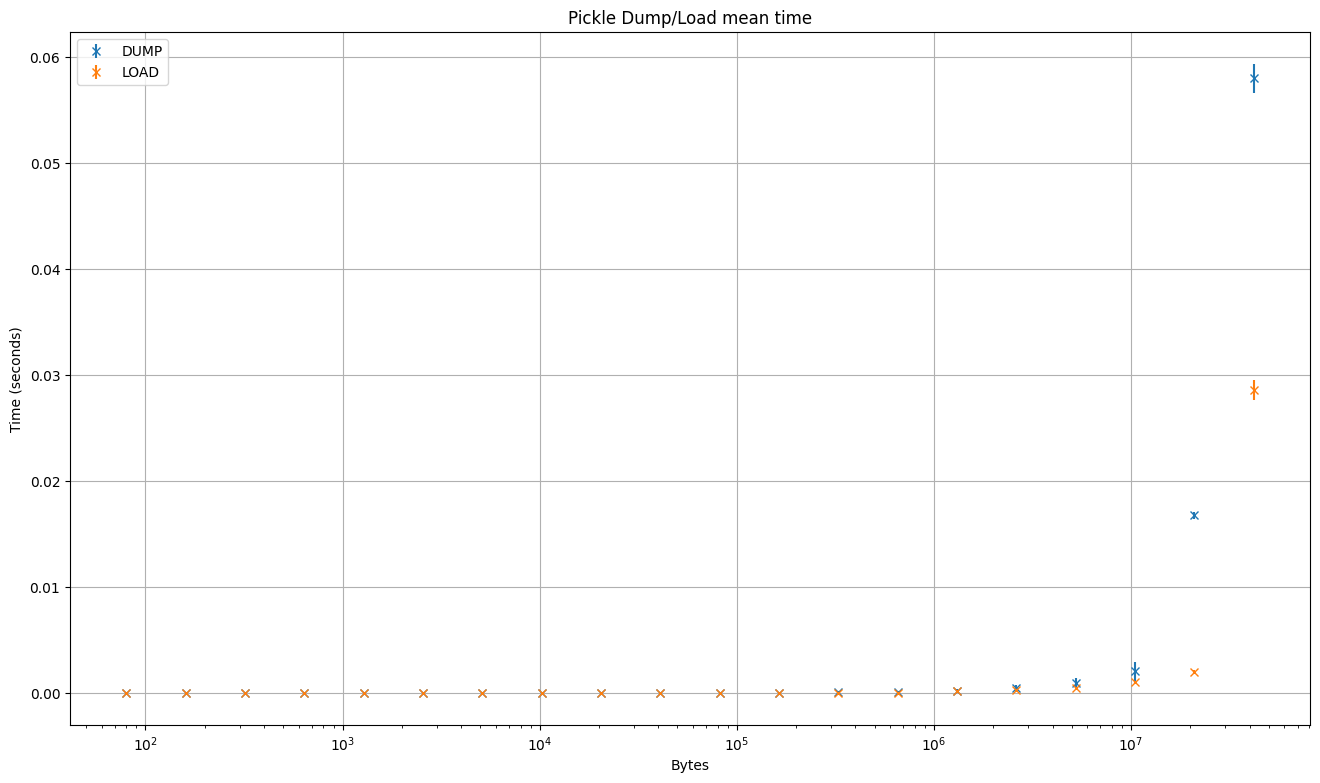

In [7]:
plt.figure(figsize=(16, 9))
plt.title("Pickle Dump/Load mean time")
plt.xlabel("Bytes")
plt.ylabel("Time (seconds)")

plt.errorbar(
    dims * 8, dump_means, dump_stds, linestyle="None", marker="x", label="DUMP"
)
plt.errorbar(
    dims * 8, load_means, load_stds, linestyle="None", marker="x", label="LOAD"
)

plt.legend()
plt.xscale("log")
plt.grid()
plt.show()

In [8]:
data = pickle.dumps(1)
pickle.loads(data)

1

Analisi per parallelismo